In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-lightning
!pip install wandb
!pip install transformers
!pip install sentencepiece
!pip install datasets
!pip install ml_things
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
import wandb

wandb.init(project="CS505-MiniLM-Spanish", entity="sks99")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
from ml_things import plot_dict, plot_confusion_matrix, fix_text

In [2]:
num_labels = 26
model_type = 'microsoft/Multilingual-MiniLM-L12-H384'

In [3]:
def read_from_file(filename):
    file = open(filename,"r")
    vocab = file.read().splitlines()
    return vocab

In [4]:
es_train_data_path = "/content/drive/MyDrive/505/Project Data/train/spanish/es_train.txt.text"
es_train_labels_path = "/content/drive/MyDrive/505/Project Data/train/spanish/es_train.txt.labels"
es_train_data = read_from_file(es_train_data_path)
es_train_labels = read_from_file(es_train_labels_path)
es_train_labels = [int(label) for label in es_train_labels]

In [5]:
from transformers import XLMRobertaTokenizer
checkpoint = model_type
tokenizer_minilm = XLMRobertaTokenizer.from_pretrained(checkpoint, do_lower_case=True)

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/430 [00:00<?, ?B/s]

In [6]:
max_len = 0

# For every sentence...
for sent in es_train_data[:1000]:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer_minilm.encode(sent, add_special_tokens=True)
    #print(sent1,sent2)
    #print(input_ids)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  45


In [7]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [8]:
import torch
def process_trainingdata(tokenizer, training_set, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  token_type_ids=[]

  # For every sentence...
  for sent in training_set:
    encoded_dict = tokenizer(
                        sent,                     # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 160,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', training_set[0])
  print('Token IDs:', input_ids[0])
  return input_ids,attention_masks,labels

In [9]:
input_ids_minilm, attention_masks_minilm, labels_minilm = process_trainingdata(tokenizer_minilm, es_train_data, es_train_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Es imposible quererte más @ Plaza Del Callao - Madrid 
Token IDs: tensor([     0,   1184, 110062, 104962,     67,   1005,   1374,  42834,   8901,
         26265,     11,     31,     20,   8884,      2,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,    

In [10]:
from torch.utils.data import TensorDataset, random_split

def datasetsize(input_ids, attention_masks, labels):
  dataset = TensorDataset(input_ids, attention_masks, labels)

  train_size = int(0.9 * len(dataset))
  val_size = len(dataset) - train_size

  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size)) 
  return train_dataset,val_dataset

In [11]:
train_dataset_minilm, val_dataset_minilm = datasetsize(input_ids_minilm, attention_masks_minilm, labels_minilm)

73,048 training samples
8,117 validation samples


In [12]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
def dataloader(size,train_dataset,val_dataset):
  batch_size = size
 
  train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
  validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
  return train_dataloader, validation_dataloader

In [13]:
train_dataloader_minilm, validation_dataloader_minilm = dataloader(16, train_dataset_minilm, val_dataset_minilm)

In [ ]:
from transformers import AutoConfig, BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model_minilm = BertForSequenceClassification.from_pretrained(
    model_type, 
    num_labels = num_labels,   
    output_attentions = False,
    output_hidden_states = False,
)

# Tell pytorch to run this model on the GPU.
model_minilm.cuda()

In [15]:
def optimizer(model):
  optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
  return optimizer

In [16]:
optimizer_minilm = optimizer(model_minilm)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [17]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
def scheduler(train_dataloader,optimizer):
  epochs = 10

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps) 
  return scheduler

In [18]:
scheduler_minilm = scheduler(train_dataloader_minilm,optimizer_minilm)

In [19]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:
def save(model, path):
    # save
    torch.save(model.state_dict(), path)

In [22]:
import random
import numpy as np

def modeltraining(model,train_dataloader,validation_dataloader,optimizer,scheduler):

  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = []

  total_t0 = time.time()
  epochs = 5
  all_loss = {'train_loss':[], 'val_loss':[]}
  all_acc = {'train_acc':[], 'val_acc':[]}

  for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    total_train_accuracy = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        if step % 5000 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_accuracy += flat_accuracy(logits.detach().cpu().numpy(), b_labels.to('cpu').numpy())
        wandb.log({"train_acc" : total_train_accuracy})
        wandb.log({"train_loss" : loss})

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

        
    save(model, '/content/drive/MyDrive/505/Project Data/MiniLM/model/MiniLM_spanish.cpkt')

    avg_train_acc = total_train_accuracy / len(train_dataloader) 
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)
    

    print("")
    print("  Average training Accuracy: {0:.2f}".format(avg_train_acc))
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for step, batch in enumerate(validation_dataloader):        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        wandb.log({"val_acc" : total_eval_accuracy})
        wandb.log({"val_loss" : loss})
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)

    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Accu.': avg_train_acc,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    all_loss['train_loss'].append(avg_train_loss)
    all_loss['val_loss'].append(avg_val_loss)
    all_acc['train_acc'].append(avg_train_acc)
    all_acc['val_acc'].append(avg_val_accuracy)

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

  # Plot accuracy curves.
  plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
  return model, training_stats, all_loss, all_acc


======== Epoch 1 / 5 ========
Training...

  Average training Accuracy: 0.25
  Average training loss: 2.48
  Training epcoh took: 0:09:04

Running Validation...
  Accuracy: 0.31
  Validation Loss: 2.30
  Validation took: 0:00:16

======== Epoch 2 / 5 ========
Training...

  Average training Accuracy: 0.32
  Average training loss: 2.25
  Training epcoh took: 0:08:55

Running Validation...
  Accuracy: 0.32
  Validation Loss: 2.24
  Validation took: 0:00:16

======== Epoch 3 / 5 ========
Training...

  Average training Accuracy: 0.34
  Average training loss: 2.16
  Training epcoh took: 0:08:55

Running Validation...
  Accuracy: 0.33
  Validation Loss: 2.21
  Validation took: 0:00:16

======== Epoch 4 / 5 ========
Training...

  Average training Accuracy: 0.37
  Average training loss: 2.08
  Training epcoh took: 0:09:01

Running Validation...
  Accuracy: 0.34
  Validation Loss: 2.18
  Validation took: 0:00:16

======== Epoch 5 / 5 ========
Training...

  Average training Accuracy: 0.39
  

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


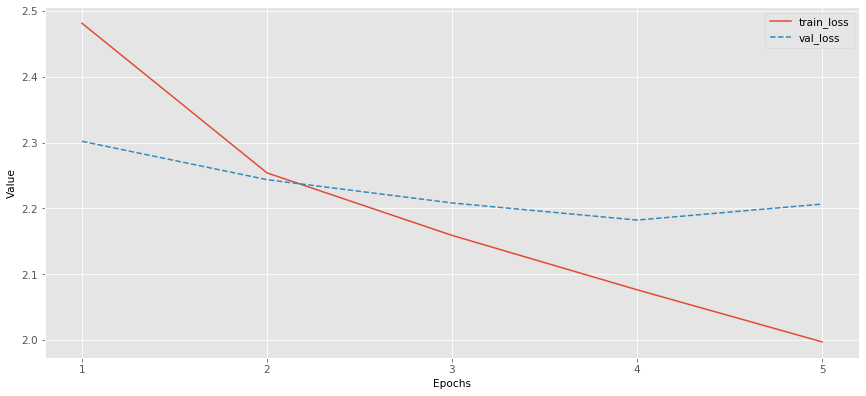

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


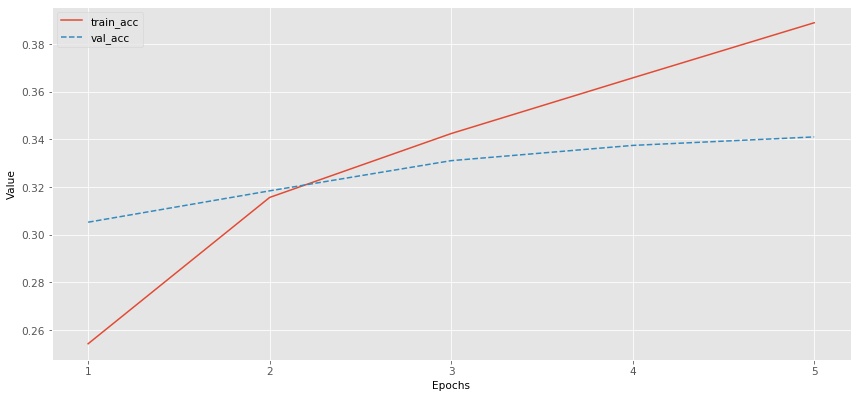

In [ ]:
model_minilm, training_stats, all_loss, all_acc = modeltraining(model_minilm,train_dataloader_minilm,validation_dataloader_minilm,optimizer_minilm,scheduler_minilm)

In [23]:
#Clear CUDA cache
import gc

gc.collect()

torch.cuda.empty_cache()

In [24]:
model_minilm.load_state_dict(torch.load('/content/drive/MyDrive/505/Project Data/MiniLM/model/MiniLM_spanish.cpkt'))

<All keys matched successfully>

In [25]:
es_test_data_path = '/content/drive/MyDrive/505/Project Data/test/es_test_modified.txt.text'
es_test_labels_path = '/content/drive/MyDrive/505/Project Data/test/es_test_modified.txt.labels'
es_test_data = read_from_file(es_test_data_path)
es_test_labels = read_from_file(es_test_labels_path)
es_test_labels = [int(label) for label in es_test_labels]

In [26]:
import torch
def process_testingdata(tokenizer, test_set, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  token_type_ids=[]

  # For every sentence...
  for sent in test_set:
    encoded_dict = tokenizer(
                        sent,                     # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 160,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Set the batch size.  
  batch_size = 16 

  # Create the DataLoader.
  prediction_data = TensorDataset(input_ids, attention_masks, labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  return prediction_dataloader

In [27]:
prediction_dataloader = process_testingdata(tokenizer_minilm, es_test_data, es_test_labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [28]:
def predicttestset(model,prediction_dataloader):
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []
  total_eval_accuracy = 0
  total_eval_loss = 0

  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    # loss = result.loss
    logits = result.logits
    # total_eval_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    # print(len(logits), len(label_ids))
    total_eval_accuracy += flat_accuracy(logits, label_ids)
  
    # Store predictions and true labels
    predictions.append(logits.argmax(axis=-1).flatten().tolist())
    true_labels.append(label_ids)
    # print(len(predictions[0]), len(true_labels[0]))
  total_acc = total_eval_accuracy*100/len(prediction_dataloader)
  # total_loss = total_eval_loss*100/len(prediction_dataloader)
  return total_acc, predictions, true_labels

In [29]:
total_acc, predictions, true_labels = predicttestset(model_minilm, prediction_dataloader)

In [30]:
print("Validation accuracy: ", total_acc)

Validation accuracy:  38.59


In [31]:
true_labels = [list(i) for i in true_labels]
predictions = [list(i) for i in predictions]

In [32]:
true_labels = sum(true_labels, [])
predictions = sum(predictions, [])

In [34]:
from sklearn.metrics import classification_report, accuracy_score
emoji_list_sp = ['❤', '😍', '😂', '💕', '🔥', '😊', '😎', '✨', '💙', '😘', '📷', '🇺🇸', '☀', '💜', '😉', '💯', '😁', '🎄', '📸', '😜','💪', '👌', '🇪🇸', '💞', '🎶', '💘']

evaluation_report = classification_report(true_labels, predictions, zero_division=1)
# Show the evaluation report.
print(evaluation_report)

              precision    recall  f1-score   support

           0       0.61      0.72      0.66      2141
           1       0.25      0.61      0.36      1408
           2       0.49      0.58      0.54      1499
           3       0.00      0.00      0.00       352
           5       0.10      0.14      0.12       514
           6       0.00      0.00      0.00       339
           7       0.24      0.06      0.10       416
           8       1.00      0.00      0.00       413
           9       0.23      0.17      0.19       397
          13       1.00      0.00      0.00       235
          14       0.10      0.02      0.03       453
          16       1.00      0.00      0.00       209
          19       1.00      0.00      0.00       274
          20       0.37      0.39      0.38       307
          21       0.14      0.02      0.04       180
          22       0.45      0.56      0.50       424
          23       1.00      0.00      0.00        93
          24       0.19    

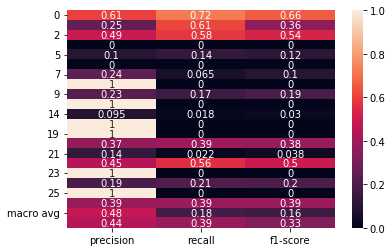

In [35]:
import pandas as pd
import seaborn as sns
evaluation_report = classification_report(true_labels, predictions, output_dict=True, zero_division=1)
sns.heatmap(pd.DataFrame(evaluation_report).iloc[:-1, :].T, annot=True)

## Top k accuracy

In [36]:
def flat_accuracy_topk(preds, labels, topk):
    count = 0
    labels_flat = labels.flatten()
    for i in range(len(preds)):
      logits = preds[i].argsort()[::-1][:topk]
      if labels[i] in logits:
        count += 1
    return count / len(labels_flat)

In [37]:
def predicttestset_topk(model, prediction_dataloader, topk):
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []
  total_eval_accuracy = 0
  total_eval_loss = 0

  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    # loss = result.loss
    logits = result.logits
    # total_eval_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    # print(len(logits), len(label_ids))
    total_eval_accuracy += flat_accuracy_topk(logits, label_ids, topk)
    # print(total_eval_accuracy)
    # return
    # Store predictions and true labels
    predictions.append(logits.argmax(axis=-1).flatten().tolist())
    true_labels.append(label_ids)
    # print(len(predictions[0]), len(true_labels[0]))
  total_acc = total_eval_accuracy*100/len(prediction_dataloader)
  # total_loss = total_eval_loss*100/len(prediction_dataloader)
  return total_acc, predictions, true_labels

In [ ]:
top_5_acc, predictions, true_labels = predicttestset_topk(model_minilm, prediction_dataloader, 5)
print("Top 5 Accuracy:", top_5_acc)

Top 5 Accuracy: 69.09


In [ ]:
top_3_acc, predictions, true_labels = predicttestset_topk(model_minilm, prediction_dataloader, 3)
print("Top 3 Accuracy:", top_3_acc)

Top 3 Accuracy: 57.53


## Zero shot performance

In [38]:
en_test_data_path = "/content/drive/MyDrive/505/Project Data/test/us_test.text"
en_test_labels_path = "/content/drive/MyDrive/505/Project Data/test/us_test.labels"
en_test_data = read_from_file(en_test_data_path)
en_test_data = [" ".join(filter(lambda x:x[0]!='@', a.split())) for a in en_test_data]
en_test_data = [" ".join(filter(lambda x:x[0]!='', a.split())) for a in en_test_data]
en_test_labels = read_from_file(en_test_labels_path)
en_test_labels = [int(label) for label in en_test_labels]
zero_shot_dataloader = process_testingdata(tokenizer_minilm, en_test_data, en_test_labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [39]:
zero_shot_total_acc, zero_shot_predictions, zero_shot_true_labels = predicttestset(model_minilm, zero_shot_dataloader)

In [40]:
print("Validation accuracy: ", zero_shot_total_acc)

Validation accuracy:  29.178


In [ ]:
zero_shot_true_labels = [list(i) for i in zero_shot_true_labels]
zero_shot_predictions = [list(i) for i in zero_shot_predictions]

In [ ]:
zero_shot_true_labels = sum(zero_shot_true_labels, [])
zero_shot_predictions = sum(zero_shot_predictions, [])

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

zero_shot_evaluation_report = classification_report(zero_shot_true_labels, zero_shot_predictions, zero_division=1, target_names=emoji_list_sp)
# Show the evaluation report.
print(zero_shot_evaluation_report)

              precision    recall  f1-score   support

           0       0.61      0.89      0.72     10798
           1       0.18      0.62      0.28      4830
           2       0.32      0.30      0.31      4534
           3       0.14      0.00      0.00      2605
           4       1.00      0.00      0.00      3716
           5       0.06      0.22      0.09      1613
           6       0.05      0.00      0.00      1996
           7       0.19      0.08      0.11      2749
           8       1.00      0.00      0.00      1549
           9       0.11      0.02      0.03      1175
          10       1.00      0.00      0.00      1432
          11       1.00      0.00      0.00      1949
          12       1.00      0.00      0.00      1265
          13       1.00      0.00      0.00      1114
          14       0.07      0.05      0.06      1306
          15       1.00      0.00      0.00      1244
          16       1.00      0.00      0.00      1153
          17       1.00    

### Zero shot top k accuracy

In [ ]:
zero_shot_top_5_acc, zero_shot_predictions, zero_shot_true_labels = predicttestset_topk(model_minilm, zero_shot_dataloader, 5)
print("Top 5 accuracy:", zero_shot_top_5_acc)

Top 5 accuracy: 48.684


In [ ]:
zero_shot_top_3_acc, zero_shot_predictions, zero_shot_true_labels = predicttestset_topk(model_minilm, zero_shot_dataloader, 3)
print("Top 3 accuracy:", zero_shot_top_3_acc)

Top 3 accuracy: 40.2
